In [1]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.layers import SimpleRNN, GRU
from tensorflow.keras.layers import Dropout, InputLayer, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

import warnings
warnings.filterwarnings(action='ignore')

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic",
        rc={"axes.unicode_minus":False},
        style='darkgrid')

#GPU 사용 설정, -1이면 CPU 사용
# os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for i in range(len(gpus)):
            tf.config.experimental.set_memory_growth(gpus[i], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# 시계열, LSTM

In [2]:
# 2. LSTM model
def lstm_model():
    seed_num = 42 # model_seed
    tf.random.set_seed(seed_num)

    lstm = Sequential()
    lstm.add(InputLayer(input_shape=(x.shape[1],x.shape[2])))
    lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(units=1, activation='sigmoid'))
    return lstm


path = '/project/LSH/'
with tf.device('/device:GPU:1'):
    # 1. Data load
    x = np.load(path + 'x_(7727,10,4068).npy')
    y = np.load(path + 'y_(7727,1).npy')

    # 3-1. Best model saving
    MODEL_SAVE_FOLDER_PATH = './models/'
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
        os.mkdir(MODEL_SAVE_FOLDER_PATH)

    acc_list, precision_list, recall_list, f1_list, auc_list = [], [], [], [], []
    sss = StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state = 42)

    # 4. Crossvalidation
    for seed, (train_index, test_index) in tqdm(enumerate(sss.split(x, y))):
        X_train, y_train = x[train_index,:,:], y[train_index]
        X_test, y_test = x[test_index,:,:], y[test_index]

        # 3-2. Best model saving
        model_path = MODEL_SAVE_FOLDER_PATH + 'lstm_cv.h5'

        cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                        verbose=1, save_best_only=True)
        early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=False)


        model = lstm_model()
        model.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), 
                      loss = "binary_crossentropy", metrics=['acc'])
        model.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,
                  callbacks=[early_stop, cb_checkpoint], shuffle=False)

        # 5. accuracy checking 
        
        best_model = keras.models.load_model(model_path) 
        y_pred_test = best_model.predict(X_test)

        y_pred_test[y_pred_test>0.5]=1
        y_pred_test[y_pred_test<=0.5]=0
        
        acc_list.append(accuracy_score(y_test, y_pred_test))
        precision_list.append(precision_score(y_test, y_pred_test))
        recall_list.append(recall_score(y_test, y_pred_test))
        f1_list.append(f1_score(y_test, y_pred_test))
        auc_list.append(roc_auc_score(y_test, y_pred_test))
        
    print(f'정확도 : {np.mean(acc_list)}, Precision : {np.mean(precision_list)}, Recall : {np.mean(recall_list)}, F1 : {np.mean(f1_list)}, roc_auc : {np.mean(auc_list)}')
    

0it [00:00, ?it/s]

Epoch 1/500


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-5f51d0ba7099>", line 48, in <module>
    model.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,
  File "/home/guri99/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/home/guri99/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
    tmp_logs = self.train_function(iterator)
  File "/home/guri99/.local/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/home/guri99/.local/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 910, in __call__
    result = self._call(*args, **kwds)
  File "/home/guri99/.local/lib/python3.8/site-packa

TypeError: object of type 'NoneType' has no len()

**저장해서 실행**
- 정확도 : 0.7606080206985769, Precision : 0.7987093416949494, Recall : 0.8179025423728813, F1 : 0.8066730126511616, roc_auc : 0.7443333309871052



In [ ]:
df

In [48]:
df

,0
0,0.758085
1,0.772962
2,0.756792
3,0.751617
4,0.774903
5,0.774256
6,0.773609
7,0.733506
8,0.760673
9,0.722510


In [4]:
lstm = Sequential()
lstm.add(InputLayer(input_shape=(x.shape[1],x.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))

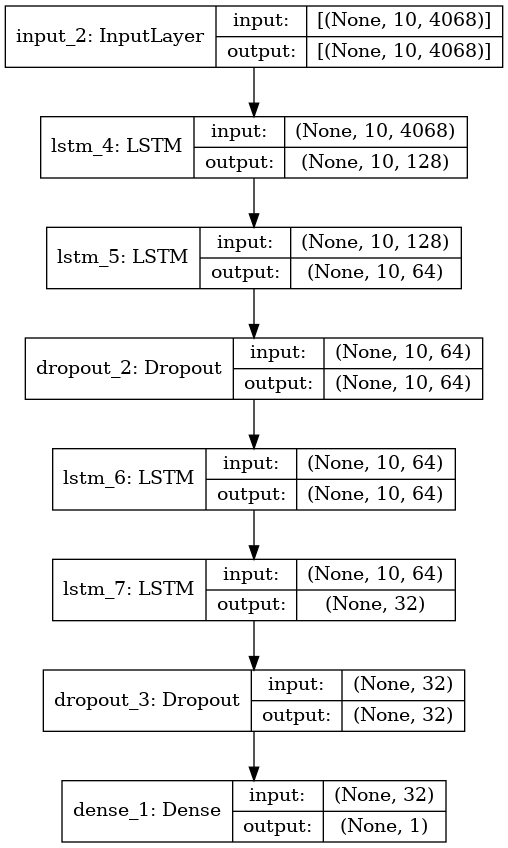

In [7]:
tf.keras.utils.plot_model(lstm, show_shapes=True)

In [5]:
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 128)           2148864   
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 64)            49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [3]:
# RNN model
def rnn_model():
    seed_num = 42 # model_seed
    tf.random.set_seed(seed_num)

    rnn = Sequential()
    rnn.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
    rnn.add(SimpleRNN(units=128, activation='relu', return_sequences=True))
    rnn.add(SimpleRNN(units=64, activation='relu', return_sequences=True))
    rnn.add(SimpleRNN(units=32, activation='relu', return_sequences=False))
    rnn.add(Dropout(0.2))
    rnn.add(Dense(units=1))
    return rnn

def gru_model(X_train):
    seed_num = 42 # model_seed
    tf.random.set_seed(seed_num)

    gru = Sequential()
    gru.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
    gru.add(GRU(units=128, activation='relu', return_sequences=True))
    gru.add(GRU(units=64, activation='relu', return_sequences=True))
    gru.add(GRU(units=32, activation='relu', return_sequences=False))
    gru.add(Dropout(0.2))
    gru.add(Dense(units=1))
    return gru

def sorted_ls(path):
    mtime=lambda f: os.stat(os.path.join(path, f)).st_mtime
    return list(sorted(os.listdir(path), key=mtime))

def bi_lstm_model():
    seed_num = 42 # model_seed
    tf.random.set_seed(seed_num)

    lstm = Sequential()
    lstm.add(InputLayer(input_shape=(x.shape[1],x.shape[2])))
    lstm.add(Bidirectional(LSTM(units=128, activation='hard_sigmoid', return_sequences=True)))
    lstm.add(Bidirectional(LSTM(units=64, activation='hard_sigmoid', return_sequences=True)))
    lstm.add(Dropout(0.2))
    lstm.add(Bidirectional(LSTM(units=64, activation='hard_sigmoid', return_sequences=True)))
    lstm.add(Bidirectional(LSTM(units=32, activation='hard_sigmoid', return_sequences=False)))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(units=1, activation='sigmoid'))
    return lstm

def bi_rnn_model():
    seed_num = 42 # model_seed
    tf.random.set_seed(seed_num)

    rnn = Sequential()
    rnn.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
    rnn.add(Bidirectional(SimpleRNN(units=128, activation='relu', return_sequences=True)))
    rnn.add(Bidirectional(SimpleRNN(units=64, activation='relu', return_sequences=True)))
    rnn.add(Bidirectional(SimpleRNN(units=32, activation='relu', return_sequences=False)))
    rnn.add(Dropout(0.2))
    rnn.add(Dense(units=1))
    return rnn

def bi_gru_model():
    seed_num = 42 # model_seed
    tf.random.set_seed(seed_num)

    gru = Sequential()
    gru.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
    gru.add(Bidirectional(GRU(units=128, activation='relu', return_sequences=True)))
    gru.add(Bidirectional(GRU(units=64, activation='relu', return_sequences=True)))
    gru.add(Bidirectional(GRU(units=32, activation='relu', return_sequences=False)))
    gru.add(Dropout(0.2))
    gru.add(Dense(units=1))
    return gru

In [4]:
#lstm과 구조 동일하게
def rnn_model(X_train):    
    rnn = Sequential()
    rnn.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
    rnn.add(SimpleRNN(units=128, activation='hard_sigmoid', return_sequences=True))
    rnn.add(SimpleRNN(units=64, activation='hard_sigmoid', return_sequences=True))
    rnn.add(Dropout(0.2))
    rnn.add(SimpleRNN(units=64, activation='hard_sigmoid', return_sequences=True))
    rnn.add(SimpleRNN(units=32, activation='hard_sigmoid', return_sequences=False))
    rnn.add(Dropout(0.2))
    rnn.add(Dense(units=1, activation='sigmoid'))
    return rnn

def gru_model(X_train):
    gru = Sequential()
    gru.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
    gru.add(GRU(units=128, activation='hard_sigmoid', return_sequences=True))
    gru.add(GRU(units=64, activation='hard_sigmoid', return_sequences=True))
    gru.add(Dropout(0.2))
    gru.add(GRU(units=64, activation='hard_sigmoid', return_sequences=True))
    gru.add(GRU(units=32, activation='hard_sigmoid', return_sequences=False))
    gru.add(Dropout(0.2))
    gru.add(Dense(units=1, activation='sigmoid'))
    return gru

In [8]:
def time_series_cv(name):
    path = '/project/LSH/'
    with tf.device('/device:GPU:0'):
        # 1. Data load
        x = np.load(path + 'x_(7727,10,4068).npy')
        y = np.load(path + 'y_(7727,1).npy')

        # 3-1. Best model saving
        MODEL_SAVE_FOLDER_PATH = './models/'
        if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
            os.mkdir(MODEL_SAVE_FOLDER_PATH)

        data={}
        acc_list, precision_list, recall_list, f1_list, auc_list = [], [], [], [], []
        sss = StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state = 42)

        # 4. Crossvalidation
        for seed, (train_index, test_index) in tqdm(enumerate(sss.split(x, y))):
            X_train, y_train = x[train_index,:,:], y[train_index]
            X_test, y_test = x[test_index,:,:], y[test_index]

            # 3-2. Best model saving
#             model_path = MODEL_SAVE_FOLDER_PATH + name +'{epoch:02d}_val_acc:{val_acc:.4f}.hdf5'

#             cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_acc', verbose=1, save_best_only=True)
            early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=False)

            if name == 'LSTM':
                model = lstm_model()
            elif name == 'RNN':
                model = rnn_model(X_train)
            elif name == 'GRU':
                model = gru_model(X_train)
            elif name == 'Bi_LSTM':
                model = bi_lstm_model()
            elif name == 'Bi_RNN':
                model = bi_rnn_model()
            elif name == 'Bi_GRU':
                model = bi_gru_model()
                
            model.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), 
                          loss = "binary_crossentropy", metrics=['acc'])
            model.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,
                      callbacks=[early_stop], shuffle=False)

#             5. accuracy checking 
            if name == 'LSTM':
                from pathlib import Path
                paths = sorted(Path(MODEL_SAVE_FOLDER_PATH).iterdir(), key=os.path.getmtime)[-1]
                best_model_path = str(paths)
                best_model_path = MODEL_SAVE_FOLDER_PATH + sorted_ls('models/')[-1]
                print('############# model path : ', best_model_path)

                best_model = keras.models.load_model(best_model_path) 
                y_pred_test = best_model.predict(X_test, batch_size=10000, workers=-1, use_multiprocessing=True)
            else:    
                y_pred_test = model.predict(X_test, batch_size=10000, workers=-1, use_multiprocessing=True)

            y_pred_test[y_pred_test>0.5]=1
            y_pred_test[y_pred_test<=0.5]=0

            precision = precision_score(y_test, y_pred_test)
            recall = recall_score(y_test, y_pred_test)
            f1 = f1_score(y_test, y_pred_test)
            roc_auc = roc_auc_score(y_test, y_pred_test)
            acc = accuracy_score(y_test, y_pred_test)

            acc_list.append(acc)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
            auc_list.append(roc_auc)

        print(f'정확도 : {np.mean(acc_list)}, Precision : {np.mean(precision_list)}, Recall : {np.mean(recall_list)}, \
                          F1 : {np.mean(f1_list)}, roc_auc : {np.mean(auc_list)}')   

In [9]:
rnn_df = time_series_cv('RNN')
rnn_df

0it [00:00, ?it/s]

Epoch 1/500
37/37 [==============================] - 5s 66ms/step - loss: 0.7018 - acc: 0.5594 - val_loss: 0.6708 - val_acc: 0.6054
Epoch 2/500
37/37 [==============================] - 2s 42ms/step - loss: 0.6781 - acc: 0.5937 - val_loss: 0.6649 - val_acc: 0.6054
Epoch 3/500
37/37 [==============================] - 2s 42ms/step - loss: 0.6522 - acc: 0.6145 - val_loss: 0.6114 - val_acc: 0.6675
Epoch 4/500
37/37 [==============================] - 2s 42ms/step - loss: 0.5539 - acc: 0.7169 - val_loss: 0.5354 - val_acc: 0.7387
Epoch 5/500
37/37 [==============================] - 2s 42ms/step - loss: 0.4552 - acc: 0.7974 - val_loss: 0.5288 - val_acc: 0.7477
Epoch 6/500
37/37 [==============================] - 2s 43ms/step - loss: 0.3926 - acc: 0.8328 - val_loss: 0.5529 - val_acc: 0.7413
Epoch 7/500
37/37 [==============================] - 2s 44ms/step - loss: 0.3534 - acc: 0.8552 - val_loss: 0.5900 - val_acc: 0.7354
Epoch 8/500
37/37 [==============================] - 2s 44ms/step - loss: 0.

37/37 [==============================] - 2s 42ms/step - loss: 0.2523 - acc: 0.9025 - val_loss: 0.7691 - val_acc: 0.6979
Epoch 13/500
37/37 [==============================] - 2s 41ms/step - loss: 0.2697 - acc: 0.8977 - val_loss: 0.6330 - val_acc: 0.7581
Epoch 14/500
37/37 [==============================] - 2s 42ms/step - loss: 0.2017 - acc: 0.9333 - val_loss: 0.7264 - val_acc: 0.7387
Epoch 15/500
37/37 [==============================] - 2s 42ms/step - loss: 0.1826 - acc: 0.9424 - val_loss: 0.7826 - val_acc: 0.7322
Epoch 16/500
37/37 [==============================] - 2s 50ms/step - loss: 0.1700 - acc: 0.9489 - val_loss: 0.8161 - val_acc: 0.7322
Epoch 17/500
37/37 [==============================] - 2s 43ms/step - loss: 0.1638 - acc: 0.9528 - val_loss: 0.8360 - val_acc: 0.7335
Epoch 18/500
37/37 [==============================] - 2s 42ms/step - loss: 0.1612 - acc: 0.9525 - val_loss: 0.8648 - val_acc: 0.7458
Epoch 19/500
37/37 [==============================] - 2s 43ms/step - loss: 0.1922 

37/37 [==============================] - 2s 43ms/step - loss: 0.1299 - acc: 0.9674 - val_loss: 0.8752 - val_acc: 0.7309
Epoch 27/500
37/37 [==============================] - 2s 41ms/step - loss: 0.1262 - acc: 0.9683 - val_loss: 0.8884 - val_acc: 0.7270
Epoch 28/500
37/37 [==============================] - 2s 41ms/step - loss: 0.1222 - acc: 0.9694 - val_loss: 0.8989 - val_acc: 0.7303
Epoch 29/500
37/37 [==============================] - 2s 41ms/step - loss: 0.1211 - acc: 0.9715 - val_loss: 0.9010 - val_acc: 0.7257
Epoch 30/500
37/37 [==============================] - 2s 41ms/step - loss: 0.1188 - acc: 0.9709 - val_loss: 0.9212 - val_acc: 0.7283
Epoch 31/500
37/37 [==============================] - 2s 59ms/step - loss: 0.1186 - acc: 0.9709 - val_loss: 0.9238 - val_acc: 0.7283
Epoch 32/500
37/37 [==============================] - 2s 43ms/step - loss: 0.1166 - acc: 0.9722 - val_loss: 0.9307 - val_acc: 0.7264
Epoch 33/500
37/37 [==============================] - 2s 42ms/step - loss: 0.1149 

37/37 [==============================] - 1s 40ms/step - loss: 0.1516 - acc: 0.9515 - val_loss: 0.8747 - val_acc: 0.7309
Epoch 28/500
37/37 [==============================] - 1s 40ms/step - loss: 0.1277 - acc: 0.9635 - val_loss: 0.9902 - val_acc: 0.7296
Epoch 29/500
37/37 [==============================] - 1s 40ms/step - loss: 0.1391 - acc: 0.9599 - val_loss: 1.0045 - val_acc: 0.7251
Epoch 30/500
37/37 [==============================] - 1s 40ms/step - loss: 0.1449 - acc: 0.9584 - val_loss: 1.0244 - val_acc: 0.7206
Epoch 31/500
37/37 [==============================] - 1s 40ms/step - loss: 0.1552 - acc: 0.9534 - val_loss: 1.1120 - val_acc: 0.7141
Epoch 32/500
37/37 [==============================] - 1s 40ms/step - loss: 0.1660 - acc: 0.9467 - val_loss: 1.1780 - val_acc: 0.7031
Epoch 33/500
37/37 [==============================] - 1s 39ms/step - loss: 0.2286 - acc: 0.9133 - val_loss: 0.9058 - val_acc: 0.7309
Epoch 34/500
37/37 [==============================] - 2s 45ms/step - loss: 0.2956 

37/37 [==============================] - 1s 38ms/step - loss: 0.2232 - acc: 0.9225 - val_loss: 0.8593 - val_acc: 0.7245
Epoch 29/500
37/37 [==============================] - 1s 40ms/step - loss: 0.2574 - acc: 0.9074 - val_loss: 0.7165 - val_acc: 0.7393
Epoch 30/500
37/37 [==============================] - 2s 41ms/step - loss: 0.2098 - acc: 0.9299 - val_loss: 0.7218 - val_acc: 0.7432
Epoch 31/500
37/37 [==============================] - 1s 40ms/step - loss: 0.1555 - acc: 0.9590 - val_loss: 0.7653 - val_acc: 0.7361
Epoch 32/500
37/37 [==============================] - 1s 40ms/step - loss: 0.1441 - acc: 0.9627 - val_loss: 0.7953 - val_acc: 0.7348
Epoch 33/500
37/37 [==============================] - 1s 40ms/step - loss: 0.1390 - acc: 0.9648 - val_loss: 0.8171 - val_acc: 0.7342
Epoch 34/500
37/37 [==============================] - 1s 40ms/step - loss: 0.1308 - acc: 0.9674 - val_loss: 0.8391 - val_acc: 0.7361
Epoch 35/500
37/37 [==============================] - 1s 41ms/step - loss: 0.1274 

37/37 [==============================] - 1s 40ms/step - loss: 0.0857 - acc: 0.9797 - val_loss: 0.9960 - val_acc: 0.7329
Epoch 40/500
37/37 [==============================] - 1s 40ms/step - loss: 0.0843 - acc: 0.9814 - val_loss: 1.0146 - val_acc: 0.7245
Epoch 41/500
37/37 [==============================] - 2s 47ms/step - loss: 0.0835 - acc: 0.9806 - val_loss: 1.0231 - val_acc: 0.7277
Epoch 42/500
37/37 [==============================] - 1s 40ms/step - loss: 0.0818 - acc: 0.9825 - val_loss: 1.0333 - val_acc: 0.7270
Epoch 43/500
37/37 [==============================] - 2s 42ms/step - loss: 0.0815 - acc: 0.9819 - val_loss: 1.0446 - val_acc: 0.7251
Epoch 44/500
37/37 [==============================] - 2s 42ms/step - loss: 0.0810 - acc: 0.9834 - val_loss: 1.0489 - val_acc: 0.7303
Epoch 45/500
37/37 [==============================] - 2s 42ms/step - loss: 0.0776 - acc: 0.9827 - val_loss: 1.0576 - val_acc: 0.7335
Epoch 46/500
37/37 [==============================] - 2s 42ms/step - loss: 0.0796 

In [10]:
gru_df = time_series_cv('GRU')
gru_df

0it [00:00, ?it/s]

Epoch 1/500
37/37 [==============================] - 6s 94ms/step - loss: 0.6828 - acc: 0.5858 - val_loss: 0.6710 - val_acc: 0.6054
Epoch 2/500
37/37 [==============================] - 3s 72ms/step - loss: 0.6818 - acc: 0.5873 - val_loss: 0.6695 - val_acc: 0.6054
Epoch 3/500
37/37 [==============================] - 3s 72ms/step - loss: 0.6711 - acc: 0.6078 - val_loss: 0.6476 - val_acc: 0.6054
Epoch 4/500
37/37 [==============================] - 3s 70ms/step - loss: 0.5873 - acc: 0.6863 - val_loss: 0.5490 - val_acc: 0.7245
Epoch 5/500
37/37 [==============================] - 3s 70ms/step - loss: 0.4708 - acc: 0.7836 - val_loss: 0.5261 - val_acc: 0.7406
Epoch 6/500
37/37 [==============================] - 3s 70ms/step - loss: 0.4070 - acc: 0.8242 - val_loss: 0.5455 - val_acc: 0.7477
Epoch 7/500
37/37 [==============================] - 3s 71ms/step - loss: 0.3591 - acc: 0.8505 - val_loss: 0.5693 - val_acc: 0.7413
Epoch 8/500
37/37 [==============================] - 3s 72ms/step - loss: 0.

Epoch 1/500
37/37 [==============================] - 6s 82ms/step - loss: 0.6840 - acc: 0.5890 - val_loss: 0.6674 - val_acc: 0.6132
Epoch 2/500
37/37 [==============================] - 3s 70ms/step - loss: 0.6797 - acc: 0.5927 - val_loss: 0.6666 - val_acc: 0.6132
Epoch 3/500
37/37 [==============================] - 3s 70ms/step - loss: 0.6746 - acc: 0.5987 - val_loss: 0.6496 - val_acc: 0.6132
Epoch 4/500
37/37 [==============================] - 3s 76ms/step - loss: 0.6128 - acc: 0.6628 - val_loss: 0.5365 - val_acc: 0.7497
Epoch 5/500
37/37 [==============================] - 3s 72ms/step - loss: 0.5027 - acc: 0.7674 - val_loss: 0.4831 - val_acc: 0.7697
Epoch 6/500
37/37 [==============================] - 3s 73ms/step - loss: 0.4333 - acc: 0.8071 - val_loss: 0.4765 - val_acc: 0.7840
Epoch 7/500
37/37 [==============================] - 3s 73ms/step - loss: 0.3924 - acc: 0.8384 - val_loss: 0.4872 - val_acc: 0.7730
Epoch 8/500
37/37 [==============================] - 3s 72ms/step - loss: 0.

Epoch 1/500
37/37 [==============================] - 6s 92ms/step - loss: 0.6864 - acc: 0.5823 - val_loss: 0.6693 - val_acc: 0.6171
Epoch 2/500
37/37 [==============================] - 3s 70ms/step - loss: 0.6821 - acc: 0.5834 - val_loss: 0.6679 - val_acc: 0.6171
Epoch 3/500
37/37 [==============================] - 3s 72ms/step - loss: 0.6708 - acc: 0.6015 - val_loss: 0.6388 - val_acc: 0.6171
Epoch 4/500
37/37 [==============================] - 3s 71ms/step - loss: 0.5926 - acc: 0.6813 - val_loss: 0.5190 - val_acc: 0.7574
Epoch 5/500
37/37 [==============================] - 3s 70ms/step - loss: 0.4847 - acc: 0.7776 - val_loss: 0.4827 - val_acc: 0.7697
Epoch 6/500
37/37 [==============================] - 3s 73ms/step - loss: 0.4169 - acc: 0.8198 - val_loss: 0.4833 - val_acc: 0.7684
Epoch 7/500
37/37 [==============================] - 3s 72ms/step - loss: 0.3732 - acc: 0.8470 - val_loss: 0.5078 - val_acc: 0.7587
Epoch 8/500
37/37 [==============================] - 3s 71ms/step - loss: 0.

37/37 [==============================] - 3s 70ms/step - loss: 0.6718 - acc: 0.6099 - val_loss: 0.6852 - val_acc: 0.5796
Epoch 3/500
37/37 [==============================] - 3s 72ms/step - loss: 0.6634 - acc: 0.6216 - val_loss: 0.6664 - val_acc: 0.5796
Epoch 4/500
37/37 [==============================] - 3s 71ms/step - loss: 0.5901 - acc: 0.6841 - val_loss: 0.5507 - val_acc: 0.7445
Epoch 5/500
37/37 [==============================] - 3s 72ms/step - loss: 0.4742 - acc: 0.7838 - val_loss: 0.5079 - val_acc: 0.7626
Epoch 6/500
37/37 [==============================] - 3s 73ms/step - loss: 0.4111 - acc: 0.8246 - val_loss: 0.5077 - val_acc: 0.7717
Epoch 7/500
37/37 [==============================] - 3s 69ms/step - loss: 0.3619 - acc: 0.8550 - val_loss: 0.5315 - val_acc: 0.7717
Epoch 8/500
37/37 [==============================] - 3s 72ms/step - loss: 0.3216 - acc: 0.8764 - val_loss: 0.5662 - val_acc: 0.7613
Epoch 9/500
37/37 [==============================] - 3s 72ms/step - loss: 0.2824 - acc: 

Epoch 3/500
37/37 [==============================] - 3s 72ms/step - loss: 0.6741 - acc: 0.6073 - val_loss: 0.6710 - val_acc: 0.5957
Epoch 4/500
37/37 [==============================] - 3s 71ms/step - loss: 0.6528 - acc: 0.6192 - val_loss: 0.6280 - val_acc: 0.5957
Epoch 5/500
37/37 [==============================] - 3s 70ms/step - loss: 0.5673 - acc: 0.7074 - val_loss: 0.5305 - val_acc: 0.7529
Epoch 6/500
37/37 [==============================] - 3s 71ms/step - loss: 0.4614 - acc: 0.8039 - val_loss: 0.5118 - val_acc: 0.7600
Epoch 7/500
37/37 [==============================] - 3s 72ms/step - loss: 0.4000 - acc: 0.8324 - val_loss: 0.5139 - val_acc: 0.7684
Epoch 8/500
37/37 [==============================] - 3s 71ms/step - loss: 0.3612 - acc: 0.8585 - val_loss: 0.5271 - val_acc: 0.7723
Epoch 9/500
37/37 [==============================] - 3s 71ms/step - loss: 0.3272 - acc: 0.8828 - val_loss: 0.5534 - val_acc: 0.7736
Epoch 10/500
37/37 [==============================] - 3s 72ms/step - loss: 0

37/37 [==============================] - 3s 70ms/step - loss: 0.6791 - acc: 0.5996 - val_loss: 0.6664 - val_acc: 0.6138
Epoch 4/500
37/37 [==============================] - 3s 70ms/step - loss: 0.6682 - acc: 0.6058 - val_loss: 0.6428 - val_acc: 0.6138
Epoch 5/500
37/37 [==============================] - 3s 70ms/step - loss: 0.6053 - acc: 0.6658 - val_loss: 0.5359 - val_acc: 0.7464
Epoch 6/500
37/37 [==============================] - 3s 70ms/step - loss: 0.4873 - acc: 0.7786 - val_loss: 0.4940 - val_acc: 0.7594
Epoch 7/500
37/37 [==============================] - 3s 72ms/step - loss: 0.4262 - acc: 0.8147 - val_loss: 0.4952 - val_acc: 0.7678
Epoch 8/500
37/37 [==============================] - 3s 71ms/step - loss: 0.3777 - acc: 0.8408 - val_loss: 0.5138 - val_acc: 0.7704
Epoch 9/500
37/37 [==============================] - 3s 71ms/step - loss: 0.3482 - acc: 0.8591 - val_loss: 0.5362 - val_acc: 0.7652
Epoch 10/500
37/37 [==============================] - 3s 70ms/step - loss: 0.3182 - acc:

Epoch 4/500
37/37 [==============================] - 3s 71ms/step - loss: 0.5622 - acc: 0.7262 - val_loss: 0.5101 - val_acc: 0.7503
Epoch 5/500
37/37 [==============================] - 3s 69ms/step - loss: 0.4641 - acc: 0.7877 - val_loss: 0.4945 - val_acc: 0.7549
Epoch 6/500
37/37 [==============================] - 3s 69ms/step - loss: 0.4154 - acc: 0.8209 - val_loss: 0.5004 - val_acc: 0.7613
Epoch 7/500
37/37 [==============================] - 3s 71ms/step - loss: 0.3820 - acc: 0.8365 - val_loss: 0.5065 - val_acc: 0.7658
Epoch 8/500
37/37 [==============================] - 3s 71ms/step - loss: 0.3546 - acc: 0.8494 - val_loss: 0.5420 - val_acc: 0.7561
Epoch 9/500
37/37 [==============================] - 3s 72ms/step - loss: 0.3351 - acc: 0.8658 - val_loss: 0.5621 - val_acc: 0.7536
Epoch 10/500
37/37 [==============================] - 3s 72ms/step - loss: 0.3000 - acc: 0.8770 - val_loss: 0.5680 - val_acc: 0.7639
Epoch 11/500
37/37 [==============================] - 3s 71ms/step - loss: 

In [23]:
bi_lstm_df = time_series_cv('Bi_LSTM')
bi_lstm_df

0it [00:00, ?it/s]

Epoch 1/500
37/37 [==============================] - 12s 150ms/step - loss: 0.6761 - acc: 0.6056 - val_loss: 0.6703 - val_acc: 0.6054
Epoch 2/500
37/37 [==============================] - 5s 128ms/step - loss: 0.6716 - acc: 0.6065 - val_loss: 0.6616 - val_acc: 0.6054
Epoch 3/500
37/37 [==============================] - 5s 127ms/step - loss: 0.6045 - acc: 0.6675 - val_loss: 0.5589 - val_acc: 0.7206
Epoch 4/500
37/37 [==============================] - 5s 128ms/step - loss: 0.4837 - acc: 0.7799 - val_loss: 0.5224 - val_acc: 0.7464
Epoch 5/500
37/37 [==============================] - 5s 130ms/step - loss: 0.3950 - acc: 0.8306 - val_loss: 0.5505 - val_acc: 0.7387
Epoch 6/500
37/37 [==============================] - 5s 127ms/step - loss: 0.3374 - acc: 0.8634 - val_loss: 0.5919 - val_acc: 0.7426
Epoch 7/500
37/37 [==============================] - 5s 127ms/step - loss: 0.3124 - acc: 0.8766 - val_loss: 0.5885 - val_acc: 0.7348
Epoch 8/500
37/37 [==============================] - 5s 128ms/step -

Epoch 48/500
37/37 [==============================] - 5s 126ms/step - loss: 0.0572 - acc: 0.9868 - val_loss: 1.1818 - val_acc: 0.7083
Epoch 49/500
37/37 [==============================] - 5s 128ms/step - loss: 0.0589 - acc: 0.9864 - val_loss: 1.2386 - val_acc: 0.7038
Epoch 50/500
37/37 [==============================] - 5s 127ms/step - loss: 0.0639 - acc: 0.9827 - val_loss: 1.1983 - val_acc: 0.7063
Epoch 51/500
37/37 [==============================] - 5s 129ms/step - loss: 0.0545 - acc: 0.9881 - val_loss: 1.2413 - val_acc: 0.7018
Epoch 52/500
37/37 [==============================] - 5s 126ms/step - loss: 0.0516 - acc: 0.9879 - val_loss: 1.2466 - val_acc: 0.7012
Epoch 53/500
37/37 [==============================] - 5s 131ms/step - loss: 0.0533 - acc: 0.9881 - val_loss: 1.2209 - val_acc: 0.7005
Epoch 54/500
37/37 [==============================] - 5s 126ms/step - loss: 0.0518 - acc: 0.9890 - val_loss: 1.2516 - val_acc: 0.7031
Epoch 00054: early stopping
Epoch 1/500
37/37 [===============

37/37 [==============================] - 5s 127ms/step - loss: 0.1109 - acc: 0.9698 - val_loss: 0.8450 - val_acc: 0.7490
Epoch 33/500
37/37 [==============================] - 5s 126ms/step - loss: 0.1076 - acc: 0.9709 - val_loss: 0.8584 - val_acc: 0.7432
Epoch 34/500
37/37 [==============================] - 5s 126ms/step - loss: 0.1045 - acc: 0.9724 - val_loss: 0.8833 - val_acc: 0.7419
Epoch 35/500
37/37 [==============================] - 5s 128ms/step - loss: 0.0988 - acc: 0.9756 - val_loss: 0.9000 - val_acc: 0.7413
Epoch 36/500
37/37 [==============================] - 5s 127ms/step - loss: 0.0964 - acc: 0.9752 - val_loss: 0.9179 - val_acc: 0.7439
Epoch 37/500
37/37 [==============================] - 5s 126ms/step - loss: 0.0953 - acc: 0.9748 - val_loss: 0.9348 - val_acc: 0.7419
Epoch 38/500
37/37 [==============================] - 5s 126ms/step - loss: 0.0910 - acc: 0.9776 - val_loss: 0.9413 - val_acc: 0.7400
Epoch 39/500
37/37 [==============================] - 5s 128ms/step - loss:

37/37 [==============================] - 5s 126ms/step - loss: 0.1835 - acc: 0.9413 - val_loss: 0.9237 - val_acc: 0.7115
Epoch 16/500
37/37 [==============================] - 5s 128ms/step - loss: 0.2048 - acc: 0.9301 - val_loss: 0.7784 - val_acc: 0.7348
Epoch 17/500
37/37 [==============================] - 5s 126ms/step - loss: 0.2335 - acc: 0.9094 - val_loss: 0.7336 - val_acc: 0.7257
Epoch 18/500
37/37 [==============================] - 5s 127ms/step - loss: 0.2156 - acc: 0.9230 - val_loss: 0.7301 - val_acc: 0.7245
Epoch 19/500
37/37 [==============================] - 5s 127ms/step - loss: 0.1763 - acc: 0.9415 - val_loss: 0.7534 - val_acc: 0.7439
Epoch 20/500
37/37 [==============================] - 5s 128ms/step - loss: 0.1480 - acc: 0.9577 - val_loss: 0.8195 - val_acc: 0.7367
Epoch 21/500
37/37 [==============================] - 5s 128ms/step - loss: 0.1394 - acc: 0.9629 - val_loss: 0.8261 - val_acc: 0.7367
Epoch 22/500
37/37 [==============================] - 5s 128ms/step - loss:

Epoch 1/500
37/37 [==============================] - 12s 149ms/step - loss: 0.6778 - acc: 0.6052 - val_loss: 0.6754 - val_acc: 0.5964
Epoch 2/500
37/37 [==============================] - 5s 128ms/step - loss: 0.6693 - acc: 0.6142 - val_loss: 0.6665 - val_acc: 0.5964
Epoch 3/500
37/37 [==============================] - 5s 127ms/step - loss: 0.6072 - acc: 0.6690 - val_loss: 0.5783 - val_acc: 0.7141
Epoch 4/500
37/37 [==============================] - 5s 125ms/step - loss: 0.4883 - acc: 0.7732 - val_loss: 0.5019 - val_acc: 0.7633
Epoch 5/500
37/37 [==============================] - 5s 128ms/step - loss: 0.4127 - acc: 0.8209 - val_loss: 0.5140 - val_acc: 0.7561
Epoch 6/500
37/37 [==============================] - 5s 125ms/step - loss: 0.3674 - acc: 0.8481 - val_loss: 0.5335 - val_acc: 0.7633
Epoch 7/500
37/37 [==============================] - 5s 126ms/step - loss: 0.3500 - acc: 0.8539 - val_loss: 0.6423 - val_acc: 0.7458
Epoch 8/500
37/37 [==============================] - 5s 128ms/step -

Epoch 1/500
37/37 [==============================] - 12s 149ms/step - loss: 0.6838 - acc: 0.5789 - val_loss: 0.6696 - val_acc: 0.6138
Epoch 2/500
37/37 [==============================] - 5s 129ms/step - loss: 0.6781 - acc: 0.5931 - val_loss: 0.6664 - val_acc: 0.6138
Epoch 3/500
37/37 [==============================] - 5s 125ms/step - loss: 0.6776 - acc: 0.5970 - val_loss: 0.6622 - val_acc: 0.6138
Epoch 4/500
37/37 [==============================] - 5s 127ms/step - loss: 0.6442 - acc: 0.6362 - val_loss: 0.5759 - val_acc: 0.7238
Epoch 5/500
37/37 [==============================] - 5s 127ms/step - loss: 0.5303 - acc: 0.7497 - val_loss: 0.5105 - val_acc: 0.7413
Epoch 6/500
37/37 [==============================] - 5s 126ms/step - loss: 0.4564 - acc: 0.8041 - val_loss: 0.5035 - val_acc: 0.7620
Epoch 7/500
37/37 [==============================] - 5s 128ms/step - loss: 0.4039 - acc: 0.8326 - val_loss: 0.5056 - val_acc: 0.7671
Epoch 8/500
37/37 [==============================] - 5s 130ms/step -

Epoch 54/500
37/37 [==============================] - 5s 129ms/step - loss: 0.0833 - acc: 0.9765 - val_loss: 0.9662 - val_acc: 0.7549
Epoch 55/500
37/37 [==============================] - 5s 127ms/step - loss: 0.0980 - acc: 0.9769 - val_loss: 1.0452 - val_acc: 0.7510
Epoch 56/500
37/37 [==============================] - 5s 127ms/step - loss: 0.0802 - acc: 0.9789 - val_loss: 1.0422 - val_acc: 0.7510
Epoch 00056: early stopping
Epoch 1/500
37/37 [==============================] - 12s 149ms/step - loss: 0.6798 - acc: 0.5912 - val_loss: 0.6630 - val_acc: 0.6229
Epoch 2/500
37/37 [==============================] - 5s 128ms/step - loss: 0.6732 - acc: 0.6056 - val_loss: 0.6588 - val_acc: 0.6229
Epoch 3/500
37/37 [==============================] - 5s 127ms/step - loss: 0.6371 - acc: 0.6309 - val_loss: 0.5447 - val_acc: 0.7380
Epoch 4/500
37/37 [==============================] - 5s 127ms/step - loss: 0.5014 - acc: 0.7674 - val_loss: 0.5134 - val_acc: 0.7393
Epoch 5/500
37/37 [==================

37/37 [==============================] - 5s 127ms/step - loss: 0.0998 - acc: 0.9741 - val_loss: 0.9742 - val_acc: 0.7387
Epoch 35/500
37/37 [==============================] - 5s 128ms/step - loss: 0.0997 - acc: 0.9722 - val_loss: 1.0115 - val_acc: 0.7316
Epoch 36/500
37/37 [==============================] - 5s 129ms/step - loss: 0.1001 - acc: 0.9735 - val_loss: 1.0411 - val_acc: 0.7290
Epoch 37/500
37/37 [==============================] - 5s 126ms/step - loss: 0.0955 - acc: 0.9748 - val_loss: 1.0121 - val_acc: 0.7316
Epoch 38/500
37/37 [==============================] - 5s 127ms/step - loss: 0.0960 - acc: 0.9748 - val_loss: 0.9614 - val_acc: 0.7451
Epoch 39/500
37/37 [==============================] - 5s 129ms/step - loss: 0.0921 - acc: 0.9745 - val_loss: 0.9535 - val_acc: 0.7439
Epoch 40/500
37/37 [==============================] - 5s 127ms/step - loss: 0.0932 - acc: 0.9754 - val_loss: 0.9590 - val_acc: 0.7329
Epoch 41/500
37/37 [==============================] - 5s 129ms/step - loss:

In [24]:
bi_rnn_df = time_series_cv('Bi_RNN')
bi_rnn_df

0it [00:00, ?it/s]

Epoch 1/500
37/37 [==============================] - 4s 48ms/step - loss: 9.4447 - acc: 0.3877 - val_loss: 9.3388 - val_acc: 0.3946
Epoch 2/500
37/37 [==============================] - 1s 35ms/step - loss: 9.4447 - acc: 0.3877 - val_loss: 9.3388 - val_acc: 0.3946
Epoch 3/500
37/37 [==============================] - 1s 37ms/step - loss: 9.4447 - acc: 0.3877 - val_loss: 9.3388 - val_acc: 0.3946
Epoch 4/500
37/37 [==============================] - 1s 36ms/step - loss: 9.4447 - acc: 0.3877 - val_loss: 9.3388 - val_acc: 0.3946
Epoch 5/500
37/37 [==============================] - 1s 36ms/step - loss: 9.4447 - acc: 0.3877 - val_loss: 9.3388 - val_acc: 0.3946
Epoch 6/500
37/37 [==============================] - 1s 36ms/step - loss: 9.4447 - acc: 0.3877 - val_loss: 9.3388 - val_acc: 0.3946
Epoch 7/500
37/37 [==============================] - 1s 35ms/step - loss: 9.4447 - acc: 0.3877 - val_loss: 9.3388 - val_acc: 0.3946
Epoch 8/500
37/37 [==============================] - 1s 35ms/step - loss: 9.

37/37 [==============================] - 1s 36ms/step - loss: 0.0904 - acc: 0.9879 - val_loss: 2.8673 - val_acc: 0.7361
Epoch 22/500
37/37 [==============================] - 1s 35ms/step - loss: 0.0666 - acc: 0.9916 - val_loss: 2.7443 - val_acc: 0.7393
Epoch 23/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0635 - acc: 0.9920 - val_loss: 2.8682 - val_acc: 0.7342
Epoch 24/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0685 - acc: 0.9905 - val_loss: 2.8794 - val_acc: 0.7374
Epoch 25/500
37/37 [==============================] - 1s 35ms/step - loss: 0.1137 - acc: 0.9702 - val_loss: 2.2974 - val_acc: 0.7257
Epoch 26/500
37/37 [==============================] - 1s 36ms/step - loss: 0.1434 - acc: 0.9661 - val_loss: 2.0010 - val_acc: 0.7290
Epoch 27/500
37/37 [==============================] - 1s 36ms/step - loss: 0.1316 - acc: 0.9767 - val_loss: 2.7912 - val_acc: 0.7329
Epoch 28/500
37/37 [==============================] - 1s 35ms/step - loss: 0.0742 

37/37 [==============================] - 1s 39ms/step - loss: 9.5778 - acc: 0.3791 - val_loss: 8.9397 - val_acc: 0.4204
Epoch 41/500
37/37 [==============================] - 1s 36ms/step - loss: 9.5778 - acc: 0.3791 - val_loss: 8.9397 - val_acc: 0.4204
Epoch 42/500
37/37 [==============================] - 1s 34ms/step - loss: 9.5778 - acc: 0.3791 - val_loss: 8.9397 - val_acc: 0.4204
Epoch 43/500
37/37 [==============================] - 1s 35ms/step - loss: 9.5778 - acc: 0.3791 - val_loss: 8.9397 - val_acc: 0.4204
Epoch 44/500
37/37 [==============================] - 1s 36ms/step - loss: 9.5778 - acc: 0.3791 - val_loss: 8.9397 - val_acc: 0.4204
Epoch 45/500
37/37 [==============================] - 1s 35ms/step - loss: 9.5778 - acc: 0.3791 - val_loss: 8.9397 - val_acc: 0.4204
Epoch 46/500
37/37 [==============================] - 1s 37ms/step - loss: 9.5778 - acc: 0.3791 - val_loss: 8.9397 - val_acc: 0.4204
Epoch 47/500
37/37 [==============================] - 1s 37ms/step - loss: 9.5745 

37/37 [==============================] - 1s 34ms/step - loss: 0.1188 - acc: 0.9713 - val_loss: 1.6651 - val_acc: 0.7477
Epoch 8/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0912 - acc: 0.9804 - val_loss: 1.8347 - val_acc: 0.7445
Epoch 9/500
37/37 [==============================] - 1s 37ms/step - loss: 0.0621 - acc: 0.9883 - val_loss: 2.2945 - val_acc: 0.7380
Epoch 10/500
37/37 [==============================] - 1s 35ms/step - loss: 0.0606 - acc: 0.9905 - val_loss: 2.3837 - val_acc: 0.7322
Epoch 11/500
37/37 [==============================] - 1s 37ms/step - loss: 0.0581 - acc: 0.9940 - val_loss: 2.5317 - val_acc: 0.7400
Epoch 12/500
37/37 [==============================] - 1s 35ms/step - loss: 0.0494 - acc: 0.9950 - val_loss: 2.5765 - val_acc: 0.7477
Epoch 13/500
37/37 [==============================] - 1s 35ms/step - loss: 0.0441 - acc: 0.9968 - val_loss: 2.6311 - val_acc: 0.7484
Epoch 14/500
37/37 [==============================] - 1s 35ms/step - loss: 0.0429 - 

37/37 [==============================] - 1s 36ms/step - loss: 0.0269 - acc: 0.9983 - val_loss: 3.0751 - val_acc: 0.7367
Epoch 26/500
37/37 [==============================] - 1s 34ms/step - loss: 0.0269 - acc: 0.9981 - val_loss: 3.0690 - val_acc: 0.7322
Epoch 27/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0264 - acc: 0.9983 - val_loss: 3.0929 - val_acc: 0.7354
Epoch 28/500
37/37 [==============================] - 1s 35ms/step - loss: 0.0267 - acc: 0.9983 - val_loss: 3.1418 - val_acc: 0.7335
Epoch 29/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0271 - acc: 0.9981 - val_loss: 3.1497 - val_acc: 0.7393
Epoch 30/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0266 - acc: 0.9983 - val_loss: 3.1503 - val_acc: 0.7354
Epoch 31/500
37/37 [==============================] - 1s 37ms/step - loss: 0.0270 - acc: 0.9983 - val_loss: 3.1024 - val_acc: 0.7387
Epoch 32/500
37/37 [==============================] - 1s 36ms/step - loss: 0.0267 

In [28]:
bi_gru_df = time_series_cv('Bi_GRU')
bi_gru_df

0it [00:00, ?it/s]

Epoch 1/500
37/37 [==============================] - 7s 93ms/step - loss: 1.1272 - acc: 0.5700 - val_loss: 0.6185 - val_acc: 0.6695
Epoch 2/500
37/37 [==============================] - 3s 79ms/step - loss: 0.5482 - acc: 0.7420 - val_loss: 0.5750 - val_acc: 0.7257
Epoch 3/500
37/37 [==============================] - 3s 77ms/step - loss: 0.4594 - acc: 0.8024 - val_loss: 0.6810 - val_acc: 0.7342
Epoch 4/500
37/37 [==============================] - 3s 79ms/step - loss: 0.3840 - acc: 0.8546 - val_loss: 0.7529 - val_acc: 0.7232
Epoch 5/500
37/37 [==============================] - 3s 79ms/step - loss: 0.3154 - acc: 0.8943 - val_loss: 1.4320 - val_acc: 0.7477
Epoch 6/500
37/37 [==============================] - 3s 79ms/step - loss: 0.2484 - acc: 0.9210 - val_loss: 2.2343 - val_acc: 0.7212
Epoch 7/500
37/37 [==============================] - 3s 79ms/step - loss: 0.2120 - acc: 0.9346 - val_loss: 2.0565 - val_acc: 0.7406
Epoch 8/500
37/37 [==============================] - 3s 79ms/step - loss: 0.

Epoch 52/500
37/37 [==============================] - 3s 78ms/step - loss: 0.0892 - acc: 0.9845 - val_loss: 3.0137 - val_acc: 0.7193
Epoch 00052: early stopping
Epoch 1/500
37/37 [==============================] - 7s 102ms/step - loss: 1.2520 - acc: 0.5452 - val_loss: 0.6262 - val_acc: 0.6429
Epoch 2/500
37/37 [==============================] - 3s 79ms/step - loss: 0.5972 - acc: 0.6919 - val_loss: 0.6030 - val_acc: 0.7206
Epoch 3/500
37/37 [==============================] - 3s 79ms/step - loss: 0.4908 - acc: 0.7868 - val_loss: 0.6259 - val_acc: 0.7717
Epoch 4/500
37/37 [==============================] - 3s 80ms/step - loss: 0.4622 - acc: 0.8375 - val_loss: 0.7413 - val_acc: 0.7232
Epoch 5/500
37/37 [==============================] - 3s 79ms/step - loss: 0.3756 - acc: 0.8781 - val_loss: 1.3752 - val_acc: 0.7484
Epoch 6/500
37/37 [==============================] - 3s 79ms/step - loss: 0.3279 - acc: 0.8792 - val_loss: 1.5483 - val_acc: 0.7594
Epoch 7/500
37/37 [===========================

37/37 [==============================] - 3s 77ms/step - loss: 0.0429 - acc: 0.9972 - val_loss: 3.2430 - val_acc: 0.7503
Epoch 49/500
37/37 [==============================] - 3s 78ms/step - loss: 0.0430 - acc: 0.9972 - val_loss: 3.2502 - val_acc: 0.7523
Epoch 50/500
37/37 [==============================] - 3s 78ms/step - loss: 0.0431 - acc: 0.9970 - val_loss: 3.2704 - val_acc: 0.7503
Epoch 51/500
37/37 [==============================] - 3s 78ms/step - loss: 0.0471 - acc: 0.9968 - val_loss: 3.2456 - val_acc: 0.7516
Epoch 52/500
37/37 [==============================] - 3s 78ms/step - loss: 0.0983 - acc: 0.9894 - val_loss: 2.8637 - val_acc: 0.7432
Epoch 00052: early stopping
Epoch 1/500
37/37 [==============================] - 7s 91ms/step - loss: 1.1939 - acc: 0.5454 - val_loss: 0.6805 - val_acc: 0.6779
Epoch 2/500
37/37 [==============================] - 3s 78ms/step - loss: 0.5754 - acc: 0.7049 - val_loss: 0.6278 - val_acc: 0.7290
Epoch 3/500
37/37 [==============================] - 3s 

37/37 [==============================] - 3s 79ms/step - loss: 0.0478 - acc: 0.9968 - val_loss: 3.5726 - val_acc: 0.7361
Epoch 45/500
37/37 [==============================] - 3s 79ms/step - loss: 0.0479 - acc: 0.9965 - val_loss: 3.5438 - val_acc: 0.7380
Epoch 46/500
37/37 [==============================] - 3s 79ms/step - loss: 0.0470 - acc: 0.9968 - val_loss: 3.5526 - val_acc: 0.7387
Epoch 47/500
37/37 [==============================] - 3s 79ms/step - loss: 0.0468 - acc: 0.9970 - val_loss: 3.5194 - val_acc: 0.7342
Epoch 48/500
37/37 [==============================] - 3s 79ms/step - loss: 0.0467 - acc: 0.9970 - val_loss: 3.5202 - val_acc: 0.7367
Epoch 49/500
37/37 [==============================] - 3s 77ms/step - loss: 0.0467 - acc: 0.9970 - val_loss: 3.6149 - val_acc: 0.7367
Epoch 50/500
37/37 [==============================] - 3s 78ms/step - loss: 0.0470 - acc: 0.9968 - val_loss: 3.5642 - val_acc: 0.7367
Epoch 51/500
37/37 [==============================] - 3s 79ms/step - loss: 0.0573 

37/37 [==============================] - 3s 80ms/step - loss: 0.7320 - acc: 0.8723 - val_loss: 1.7656 - val_acc: 0.7096
Epoch 41/500
37/37 [==============================] - 3s 79ms/step - loss: 0.3718 - acc: 0.8973 - val_loss: 1.9553 - val_acc: 0.7413
Epoch 42/500
37/37 [==============================] - 3s 78ms/step - loss: 0.2086 - acc: 0.9443 - val_loss: 2.0881 - val_acc: 0.7380
Epoch 43/500
37/37 [==============================] - 3s 81ms/step - loss: 0.1298 - acc: 0.9644 - val_loss: 2.4135 - val_acc: 0.7380
Epoch 44/500
37/37 [==============================] - 3s 79ms/step - loss: 0.1024 - acc: 0.9732 - val_loss: 2.4837 - val_acc: 0.7348
Epoch 45/500
37/37 [==============================] - 3s 79ms/step - loss: 0.1012 - acc: 0.9778 - val_loss: 2.6335 - val_acc: 0.7432
Epoch 46/500
37/37 [==============================] - 3s 79ms/step - loss: 0.0728 - acc: 0.9838 - val_loss: 2.7075 - val_acc: 0.7458
Epoch 47/500
37/37 [==============================] - 3s 81ms/step - loss: 0.0622 

37/37 [==============================] - 3s 80ms/step - loss: 0.0667 - acc: 0.9950 - val_loss: 2.9885 - val_acc: 0.7536
Epoch 37/500
37/37 [==============================] - 3s 79ms/step - loss: 0.0655 - acc: 0.9948 - val_loss: 3.1194 - val_acc: 0.7490
Epoch 38/500
37/37 [==============================] - 3s 79ms/step - loss: 0.0651 - acc: 0.9950 - val_loss: 3.1629 - val_acc: 0.7490
Epoch 39/500
37/37 [==============================] - 3s 78ms/step - loss: 0.0639 - acc: 0.9959 - val_loss: 3.1681 - val_acc: 0.7561
Epoch 40/500
37/37 [==============================] - 3s 79ms/step - loss: 0.0639 - acc: 0.9955 - val_loss: 3.1949 - val_acc: 0.7471
Epoch 41/500
37/37 [==============================] - 3s 80ms/step - loss: 0.0639 - acc: 0.9953 - val_loss: 3.2116 - val_acc: 0.7484
Epoch 42/500
37/37 [==============================] - 3s 79ms/step - loss: 0.0636 - acc: 0.9957 - val_loss: 3.1992 - val_acc: 0.7490
Epoch 43/500
37/37 [==============================] - 3s 79ms/step - loss: 0.0642 

# 비시계열

In [5]:
def non_time_series_cv(model):
    path = '/project/LSH/'
    with tf.device('/device:GPU:0'):
        # 1. Data load
        x = np.load(path + 'x_(7727,10,4068).npy').reshape(7727,-1)
        y = np.load(path + 'y_(7727,1).npy')

        # 3-1. Best model saving
        MODEL_SAVE_FOLDER_PATH = './models/'
        if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
            os.mkdir(MODEL_SAVE_FOLDER_PATH)

        sss = StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state = 42)
        acc_list, precision_list, recall_list, f1_list, auc_list = [], [], [], [], []

        # 4. Crossvalidation
        for seed, (train_index, test_index) in tqdm(enumerate(sss.split(x, y))):
            X_train, y_train = x[train_index,:], y[train_index]
            X_test, y_test = x[test_index,:], y[test_index]
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            
            precision = precision_score(y_test, pred)
            recall = recall_score(y_test, pred)
            f1 = f1_score(y_test, pred)
            roc_auc = roc_auc_score(y_test, pred)
            acc = accuracy_score(y_test, pred)
            
            acc_list.append(acc)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
            auc_list.append(roc_auc)
#             print(acc, precision, recall, f1, roc_auc)
        print(f'정확도 : {np.mean(acc_list)}, Precision : {np.mean(precision_list)}, Recall : {np.mean(recall_list)}, \
                      F1 : {np.mean(f1_list)}, roc_auc : {np.mean(auc_list)}')
        return [np.mean(acc_list), np.mean(precision_list), np.mean(recall_list), np.mean(f1_list), np.mean(auc_list)]

In [6]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
temp = non_time_series_cv(model)
print({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})

0it [00:00, ?it/s]

정확도 : 0.756791720569211, Precision : 0.7664918672196908, Recall : 0.8654661016949152,                       F1 : 0.8129362284185163, roc_auc : 0.7259224196182217
{'model': 'RandomForestClassifier()', 'acc': 0.756791720569211, 'precision': 0.7664918672196908, 'recall': 0.8654661016949152, 'f1': 0.8129362284185163, 'roc_auc': 0.7259224196182217}


In [ ]:
%%time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

result = []

# Support vector machine
model = SVC()
temp = non_time_series_cv(model)
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})

# Gaussian naive bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
temp = non_time_series_cv(model)
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
temp = non_time_series_cv(model)
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})

from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
temp = non_time_series_cv(model)
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})

# K nearest neighbor
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
temp = non_time_series_cv(model)
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})

# Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
temp = non_time_series_cv(model)
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})
# Gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
temp = non_time_series_cv(model)
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})
# Neural network
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(max_iter=1000)
temp = non_time_series_cv(model)
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
temp = non_time_series_cv(model)
model = AdaBoostClassifier(n_estimators=500, 
                        random_state=10, 
                        learning_rate=0.1)
result.append({'model' : str(model), 'acc' : temp[0], 'precision' : temp[1],
               'recall' : temp[2], 'f1' : temp[3], 'roc_auc' : temp[4]})


0it [00:00, ?it/s]

정확도 : 0.7753557567917205, Precision : 0.7927421359744848, Recall : 0.8560381355932204,                       F1 : 0.8231247397319994, roc_auc : 0.7524376724477729


0it [00:00, ?it/s]

정확도 : 0.5796248382923673, Precision : 0.7252389884424696, Recall : 0.5016949152542373,                       F1 : 0.5930054254445458, roc_auc : 0.6017610788895771


0it [00:00, ?it/s]

정확도 : 0.6919793014230272, Precision : 0.7488186936234366, Recall : 0.7457627118644068,                       F1 : 0.7472149930180403, roc_auc : 0.6767019539388479


0it [00:00, ?it/s]

정확도 : 0.6946959896507116, Precision : 0.785062330418927, Recall : 0.6886652542372882,                       F1 : 0.7335458367872882, roc_auc : 0.6964090390787769


0it [00:00, ?it/s]

정확도 : 0.650582147477361, Precision : 0.6766573504004152, Recall : 0.8195974576271187,                       F1 : 0.7411716286122857, roc_auc : 0.6025728151922969


0it [00:00, ?it/s]

정확도 : 0.7517464424320828, Precision : 0.7618858018095022, Recall : 0.8632415254237287,                       F1 : 0.8093515761540692, roc_auc : 0.7200759122135255


0it [00:00, ?it/s]

In [9]:
# result.append({'model' : 'LSTM', 'mean' : 0.75789133})
df = pd.DataFrame(result)
df

,model,acc,precision,recall,f1,roc_auc
0,SVC(),0.771410,0.788014,0.856038,0.820570,0.747371
1,GaussianNB(),0.483635,0.763052,0.224153,0.346155,0.557342
2,MultinomialNB(),0.677490,0.748613,0.710381,0.728956,0.668147
3,BernoulliNB(),0.681759,0.768362,0.685593,0.724521,0.680670
4,KNeighborsClassifier(),0.659056,0.664553,0.891949,0.761593,0.592901
5,DecisionTreeClassifier(),0.659056,0.664553,0.891949,0.761593,0.592901
6,RandomForestClassifier(),0.747089,0.749543,0.879873,0.809475,0.709372
7,GradientBoostingClassifier(),0.748771,0.762184,0.855614,0.806143,0.718422
8,MLPClassifier(max_iter=1000),0.733571,0.780321,0.784746,0.782432,0.719034
9,"AdaBoostClassifier(learning_rate=0.1, n_estima...",0.732406,0.780573,0.781780,0.781042,0.718382


In [36]:
df.sort_values('mean')

,model,mean
1,GaussianNB(),0.483635
2,KNeighborsClassifier(),0.659056
5,MLPClassifier(max_iter=1000),0.732471
3,RandomForestClassifier(),0.738422
4,GradientBoostingClassifier(),0.748448
6,"AdaBoostClassifier(learning_rate=0.1, n_estima...",0.752199
7,LSTM,0.757891
0,SVC(),0.771410
